# Model Interpretability — Grad-CAM and Guided Grad-CAM  
*(Brain MRI Tumor Classification)*

## Purpose
This notebook focuses on **model interpretability** by explaining *why* the trained CNN predicts a specific brain tumor class.  
We use **Grad-CAM** and **Guided Grad-CAM** to visualize which spatial regions in the MRI most influenced the model’s decision.

The objective is not only high predictive performance, but also **transparent and trustworthy decision-making**, which is especially critical in medical imaging.

---

## What Grad-CAM Visualizes (Important)
Grad-CAM generates a **class-discriminative importance map** based on gradients flowing into the **last convolutional layer** of the network.

It highlights image regions that:
- Contribute most strongly to the **predicted class score**
- Are spatially relevant at a **high semantic level**

⚠️ **Important limitation:**  
Grad-CAM does **not** represent exact tumor boundaries, segmentation masks, or medical causality.  
It provides a **model-based explanation**, not a clinical diagnosis.

---

## How to Interpret the Colors
Grad-CAM heatmaps are normalized and color-mapped:

- **Warm colors (red / yellow)** → regions with **high influence** on the predicted class  
- **Cool colors (blue / green)** → regions with **low influence**

The intensity reflects *relative importance*, not probability or confidence.

---

## Why Heatmaps Appear Even for “No Tumor”
Grad-CAM may still highlight regions for the **`notumor`** class because:

- The model must find **positive evidence of normality**
- Decisions rely on anatomical symmetry, texture consistency, and absence of abnormal structures

Thus, highlighted areas support the decision *“this image looks normal”*, rather than indicating pathology.

---

## Guided Grad-CAM (Optional but Informative)
Guided Grad-CAM combines:
- **Grad-CAM** (spatial localization)
- **Guided backpropagation** (fine-grained edge sensitivity)

This produces **high-resolution, edge-aware saliency maps**, useful for:
- Inspecting local texture cues
- Verifying that the model responds to meaningful anatomical structures

Guided Grad-CAM should be interpreted carefully, as it may amplify noise and is less robust than standard Grad-CAM.

---

## Workflow Overview
1. Load the best-performing saved model (checkpoint)
2. Select representative test images from each class
3. Compute Grad-CAM heatmaps using the last convolutional layer
4. Overlay heatmaps on the original MRI images
5. Compare attention patterns across tumor classes
6. Apply Guided Grad-CAM for detailed saliency inspection

---

## Key Takeaway
> Grad-CAM helps verify that the model’s high accuracy is driven by **clinically plausible visual features**, rather than spurious correlations.

This interpretability step strengthens confidence in the model and provides essential context for responsible use in medical AI research.

## Environment Setup and Imports (Grad-CAM Notebook)

This cell initializes the notebook environment and imports all required libraries for **model interpretability** using Grad-CAM.

Key dependencies:
- **TensorFlow / Keras (`tf`, `Model`, `load_model`, `backend`)**  
  Used to load the trained CNN and compute gradients needed for Grad-CAM.
- **OpenCV (`cv2`) and NumPy (`np`)**  
  Used for image preprocessing, resizing, and heatmap overlay operations.
- **Matplotlib (`plt`)**  
  Used for visualizing MRI images, Grad-CAM heatmaps, and overlays inline.
- **ImageIO (`imageio`)**  
  Optional utility for robust image I/O and visualization workflows.
- **OS / random / warnings**  
  Used for file handling, random sampling of images, and cleaner notebook output.

`%matplotlib inline` ensures all heatmaps and overlays render directly in the notebook.  
Warnings are suppressed to keep the output readable during iterative visualization.

In [45]:
%matplotlib inline
%pip install imageio


import os
import random
import warnings

import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img

warnings.filterwarnings("ignore")


Note: you may need to restart the kernel to use updated packages.


## Model and Input Configuration for Grad-CAM

This block defines the input configuration and loads the trained CNN model used for Grad-CAM analysis.

- `IMG_SIZE = (200, 200)` matches the spatial resolution used during model training, ensuring that input preprocessing remains consistent.
- `IMG_PATH` specifies a representative test MRI image for which interpretability analysis will be performed.
- The trained model is loaded from disk using `load_model`, with compilation disabled since Grad-CAM requires only forward passes and gradient computation, not training.

Loading the model in this way ensures that Grad-CAM visualizations are generated from the **exact trained model state**, preserving consistency between quantitative evaluation results and qualitative explanation maps.

In [46]:
IMG_SIZE = (200, 200)
IMG_PATH = r"/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/meningioma/Te-me_0023.jpg"

MODEL_PATH = "/Users/shammi/Documents/Projects/BrainTumorProject/best_model.h5"
model = load_model(MODEL_PATH, compile=False)
print("Loaded:", MODEL_PATH)


Loaded: /Users/shammi/Documents/Projects/BrainTumorProject/best_model.h5


## Input Image Selection and Visualization

This block loads a single MRI image from the test dataset and displays it for reference prior to Grad-CAM analysis.

The image is resized to **200 × 200 pixels**, matching the input resolution used during model training.  
Visualizing the raw input image establishes a baseline against which the Grad-CAM heatmap overlay can later be compared.

This step ensures that:
- The correct image is being analyzed.
- Image orientation and appearance are as expected.
- Any highlighted regions in subsequent Grad-CAM visualizations can be interpreted relative to the original MRI scan.

Displaying the original image before applying interpretability methods is essential for transparent and meaningful explanation of model behavior.

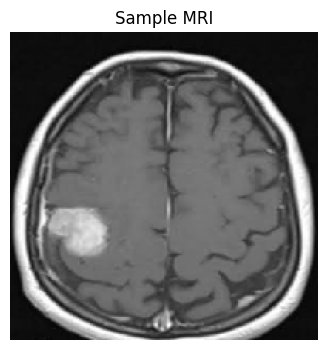

In [47]:
image = np.array(load_img(IMG_PATH, target_size=(*IMG_SIZE, 3)))

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title("Sample MRI")
plt.axis("off")
plt.show()

## Load Best Checkpoint for Grad-CAM Analysis

The model is reloaded from the **best-performing checkpoint** saved during training.  
This checkpoint corresponds to the model state with the **lowest validation loss**, ensuring that Grad-CAM explanations are generated from the most generalizable version of the network.

Using the best validation model avoids interpreting weights from later epochs that may exhibit mild overfitting, thereby improving the reliability of the visual explanations.

In [48]:
model = load_model("best_model.h5")

## Grad-CAM Implementation (Automatic Last Conv Layer + Gradient-Based Heatmap)

This function implements **Grad-CAM (Gradient-weighted Class Activation Mapping)** to explain a CNN prediction by highlighting which spatial regions most influenced the predicted class.

### Core idea (what Grad-CAM computes)
Grad-CAM produces a **class-specific importance map** by combining:
1) the feature maps from the **last convolutional layer**, and  
2) the gradients of the predicted class score with respect to those feature maps.

Warm regions in the resulting heatmap indicate areas that contribute more strongly to the selected class score, while cooler regions contribute less.  
This is a model-based explanation of **influence**, not a guaranteed medical ground-truth segmentation.

### Step-by-step logic in this implementation
**Step 1 — Preprocess and predict**
- The input image is converted to `float32` and expanded to a batch shape `(1, H, W, C)`.
- A forward pass generates class probabilities.
- The top predicted class index (`prediction_idx`) is selected for explanation.

**Step 2 — Select the last convolutional layer automatically**
- The last `Conv2D` layer is found by iterating backwards through `model.layers`.
- This layer is used because it preserves spatial structure while being highly class-informative.

**Step 3 — Compute gradients using GradientTape**
- A `gradient_model` is created that outputs both:
  - the selected conv layer feature map, and
  - the final model prediction.
- The loss is defined as the predicted score of the target class.
- Gradients of this loss w.r.t. the conv feature map are computed.

**Step 4 — Channel weighting and heatmap construction**
- Gradients are globally averaged across spatial dimensions to obtain one weight per channel.
- A weighted sum of the conv feature maps produces the raw class activation map.
- ReLU (`max(.,0)`) is applied to keep only positive contributions.
- The activation map is resized to the original image resolution and normalized to 0–255.

**Step 5 — Overlay visualization**
- The heatmap is colorized and blended with the original image using an `interpolant` factor:
  - higher `interpolant` shows more of the original image,
  - lower `interpolant` shows more of the heatmap.

### Practical notes (to avoid runtime errors)
- `img_to_array` must be imported (e.g., `from tensorflow.keras.preprocessing.image import img_to_array`) before use.
- The print statement should reference the selected layer name:
  - replace `LAST_CONV_LAYER_NAME` with `last_conv_layer.name` to avoid undefined variables.

In [49]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model


In [50]:
def IntegrationwithGradCam(model, image, interpolant=0.5, plot_results=True):


    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    print("Auto-selected conv layer:", LAST_CONV_LAYER_NAME)

    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]

    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

## Running Grad-CAM on a Single Test Image (Preprocessing + Layer Verification)

This block demonstrates an end-to-end Grad-CAM run on a single MRI test image.

### Input preprocessing (must match training)
- The image is loaded in **RGB mode** and resized to **200×200**, matching the model’s expected input shape.
- The image is converted into a NumPy tensor using `img_to_array`.
- Pixel values are normalized to **[0, 1]** by dividing by 255.0, which matches the most common training normalization scheme.

Maintaining identical preprocessing is critical: Grad-CAM explanations are only meaningful when the inference input representation matches the training pipeline.

### Grad-CAM execution
The processed image tensor is passed into `IntegrationwithGradCam(...)`, which:
1) performs a forward prediction,
2) identifies the most likely class,
3) computes gradients w.r.t. the last convolutional layer,
4) generates a heatmap, and
5) overlays the heatmap onto the original image.

### Interpretation of the printed layer name
The output  
`Auto-selected conv layer: conv5_block3_3_conv`  
confirms that Grad-CAM automatically selected the **final convolutional layer of ResNet-50**.  
This is the correct layer choice in most Grad-CAM setups because it is both:
- **spatially localized** (still retains a feature-map grid), and
- **highly class-informative** (close to the final decision).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Auto-selected conv layer: conv5_block3_3_conv


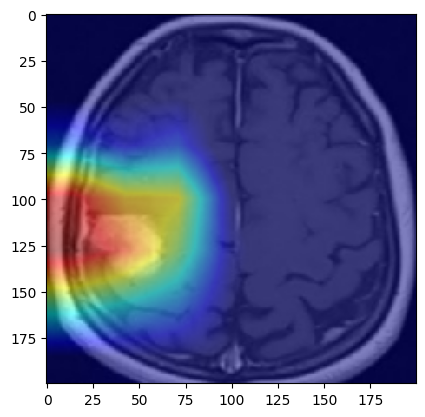

In [68]:
import numpy as np
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

IMG_SIZE = (200, 200)
IMG_PATH = r"/Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing/meningioma/Te-me_0023.jpg"

# Load as RGB (3 channels) unless you trained on grayscale
pil_img = load_img(IMG_PATH, target_size=IMG_SIZE, color_mode="rgb")
test_img = img_to_array(pil_img).astype(np.float32)

# Normalize the same way as training (most common)
test_img = test_img / 255.0

# Call Grad-CAM (your function adds batch dim internally)
IntegrationwithGradCam(model, test_img, plot_results=True)


## Grad-CAM on an Uncropped Test Image (Testingbrain Directory)

This block runs Grad-CAM on a test image taken from the original **Testingbrain** directory (i.e., before the cropped dataset structure).  
The image is resized to **200×200**, converted to a float tensor, and normalized to **[0, 1]** before being passed into the Grad-CAM function.

### Why this is useful
Using an uncropped image helps verify whether the model and Grad-CAM visualization remain stable when the input contains more background context.  
It also makes it easier to visually compare the heatmap overlay with the raw MRI image, especially when presenting examples in slides.

### Preprocessing note (important for correctness)
Grad-CAM results are meaningful only if the input preprocessing matches the model’s training pipeline.  
If the model was trained exclusively on **cropped images**, running Grad-CAM on uncropped images may shift the input distribution and could:
- slightly reduce prediction confidence, and/or
- cause the heatmap to highlight irrelevant background regions.

For strict consistency, Grad-CAM should ideally be applied to images processed in the same way as training (cropped + resized + normalized).  
This cell therefore serves as an additional robustness/diagnostic check rather than the primary interpretability result.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Auto-selected conv layer: conv5_block3_3_conv


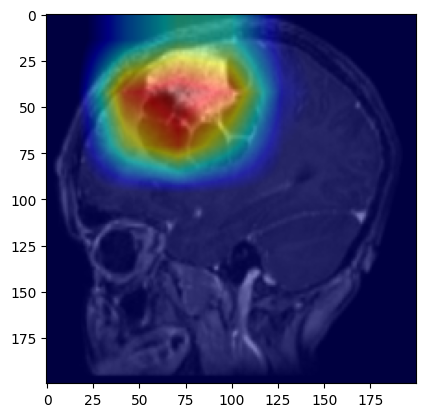

In [69]:
import numpy as np
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

IMG_SIZE = (200, 200)
IMG_PATH = r"/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/meningioma/Te-me_0067.jpg"

# Load as RGB (3 channels) unless you trained on grayscale
pil_img = load_img(IMG_PATH, target_size=IMG_SIZE, color_mode="rgb")
test_img = img_to_array(pil_img).astype(np.float32)

# Normalize the same way as training (most common)
test_img = test_img / 255.0

# Call Grad-CAM (your function adds batch dim internally)
IntegrationwithGradCam(model, test_img, plot_results=True)

## Inspecting the Raw Grad-CAM Heatmap (Before Overlay)

This block visualizes the **raw Grad-CAM heatmap** independently of the original MRI image.  
Instead of overlaying the heatmap immediately, the importance map is displayed on its own using a color scale.

### Why visualize the raw heatmap?
Inspecting the raw Grad-CAM output helps verify that:
- The heatmap is correctly computed and non-uniform.
- High-importance regions are spatially coherent rather than random noise.
- The dynamic range of values is reasonable before blending with the input image.

This step is useful for debugging and for understanding how strongly different spatial regions contribute to the model’s prediction.

### How to interpret the color scale
- **Warm colors (yellow/red)** indicate regions with **higher contribution** to the predicted class score.
- **Cool colors (blue)** indicate regions with **lower contribution**.
- The heatmap represents **relative importance**, not probability and not ground-truth segmentation.

### Heatmap value range
Printing the minimum and maximum values confirms proper normalization of the Grad-CAM output.  
A bounded range (typically 0–255 or 0–1, depending on implementation) indicates that:
- Negative contributions have been removed (via ReLU),
- The map has been scaled consistently for visualization.

Only after this validation step is the heatmap overlaid on the original MRI image for qualitative interpretation.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Auto-selected conv layer: conv5_block3_3_conv


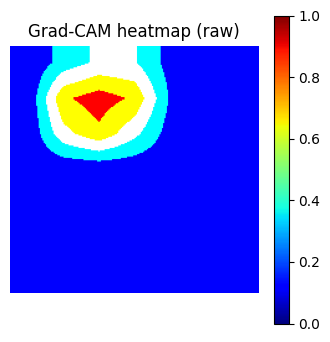

heatmap min/max: 0.0 255.0


In [70]:
heatmap = IntegrationwithGradCam(model, test_img, plot_results=False) 
plt.figure(figsize=(4,4))
plt.imshow(heatmap, cmap="jet")
plt.colorbar()
plt.title("Grad-CAM heatmap (raw)")
plt.axis("off")
plt.show()

print("heatmap min/max:", float(heatmap.min()), float(heatmap.max()))

## Contrast Enhancement of the Grad-CAM Heatmap

This block applies **contrast normalization** to the raw Grad-CAM heatmap to improve visual interpretability.

### Why contrast boosting is needed
Raw Grad-CAM heatmaps often have a **narrow dynamic range**, where most values cluster near zero.  
As a result, important regions may appear visually weak or washed out when displayed directly.

To address this, percentile-based normalization is applied:
- The **10th percentile** is treated as a lower bound.
- The **90th percentile** is treated as an upper bound.
- Values outside this range are clipped.

This approach suppresses low-importance background noise while enhancing relatively strong activations.

### What this transformation does (and does not do)
- It **rescales importance values for visualization only**.
- It does **not** change the underlying model behavior or prediction.
- It does **not** convert Grad-CAM into a probability or segmentation map.

After normalization:
- **Warm colors** represent regions with comparatively higher influence on the predicted class.
- **Cool colors** represent lower influence.

This contrast-boosted heatmap makes spatial patterns easier to analyze before overlaying the explanation on the original MRI image.


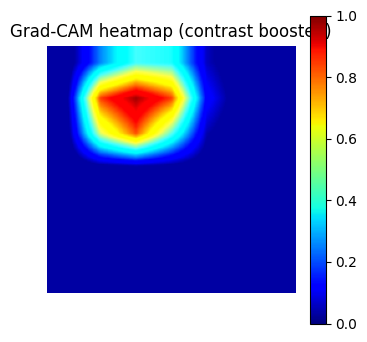

In [71]:
h = heatmap.copy()

lo, hi = np.percentile(h, (10, 90))
h = (h - lo) / (hi - lo + 1e-8)
h = np.clip(h, 0, 1)

plt.figure(figsize=(4,4))
plt.imshow(h, cmap="jet")
plt.colorbar()
plt.title("Grad-CAM heatmap (contrast boosted)")
plt.axis("off")
plt.show()

## Grad-CAM Example: “No Tumor” Case (Why a Heatmap Still Appears)

This figure shows a Grad-CAM overlay for an image predicted as **no_tumor**.  
Even in a “no tumor” case, Grad-CAM will still highlight regions because the model must rely on **positive evidence of normality** (typical anatomy, expected symmetry, consistent textures) to support the “no tumor” decision.

### How to interpret this specific overlay
- The heatmap concentrates around the **central brain region**, which suggests the model is using global structural cues from the brain area (not the black background) to make its decision.
- This does **not** mean “the model found a tumor there.”  
  It means those pixels/features contributed more strongly to the score of the **no_tumor** class than other regions.

### Color meaning (safe wording)
Warm colors (red/yellow) indicate **higher contribution to the selected class score** (here: *no_tumor*).  
Cool colors (blue) indicate **lower contribution**.

### Important limitation
Grad-CAM visualizes **influence on the prediction**, not medical causality or a precise segmentation mask.  
For “no tumor,” highlighted regions can simply represent areas the model checks to confirm the absence of abnormal patterns.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Auto-selected conv layer: conv5_block3_3_conv


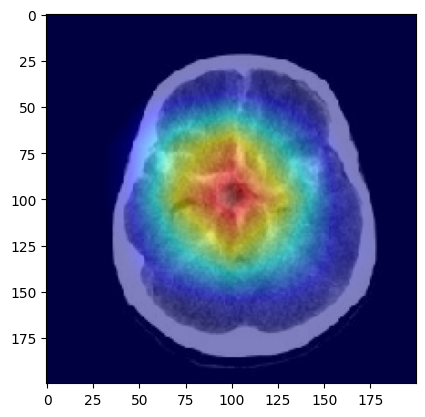

In [196]:
import numpy as np
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

IMG_SIZE = (200, 200)
IMG_PATH = r"/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/notumor/Te-no_0087.jpg"

# Load as RGB (3 channels) unless you trained on grayscale
pil_img = load_img(IMG_PATH, target_size=IMG_SIZE, color_mode="rgb")
test_img = img_to_array(pil_img).astype(np.float32)

# Normalize the same way as training (most common)
test_img = test_img / 255.0

# Call Grad-CAM (your function adds batch dim internally)
IntegrationwithGradCam(model, test_img, plot_results=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Auto-selected conv layer: conv5_block3_3_conv


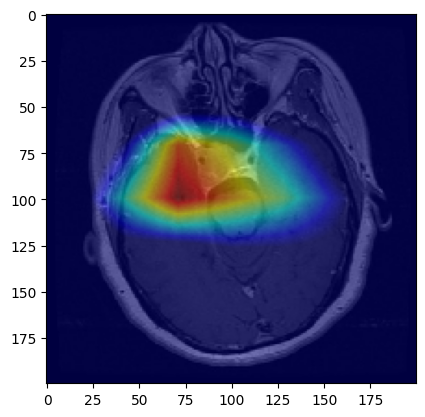

In [52]:
import numpy as np
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

IMG_SIZE = (200, 200)
IMG_PATH = r"/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/pituitary/Te-pi_0014.jpg"

# Load as RGB (3 channels) unless you trained on grayscale
pil_img = load_img(IMG_PATH, target_size=IMG_SIZE, color_mode="rgb")
test_img = img_to_array(pil_img).astype(np.float32)

# Normalize the same way as training (most common)
test_img = test_img / 255.0

# Call Grad-CAM (your function adds batch dim internally)
IntegrationwithGradCam(model, test_img, plot_results=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Auto-selected conv layer: conv5_block3_3_conv


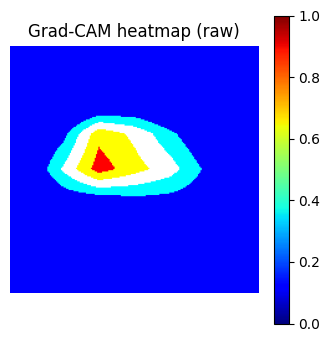

heatmap min/max: 0.0 255.0


In [54]:
heatmap = IntegrationwithGradCam(model, test_img, plot_results=False) 
plt.figure(figsize=(4,4))
plt.imshow(heatmap, cmap="jet")
plt.colorbar()
plt.title("Grad-CAM heatmap (raw)")
plt.axis("off")
plt.show()

print("heatmap min/max:", float(heatmap.min()), float(heatmap.max()))

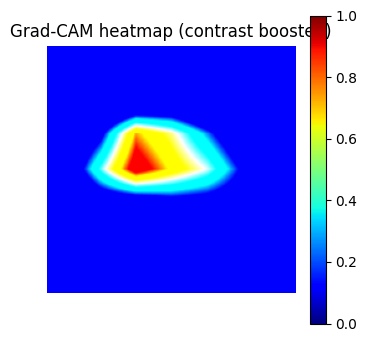

In [55]:
h = heatmap.copy()

lo, hi = np.percentile(h, (10, 90))
h = (h - lo) / (hi - lo + 1e-8)
h = np.clip(h, 0, 1)

plt.figure(figsize=(4,4))
plt.imshow(h, cmap="jet")
plt.colorbar()
plt.title("Grad-CAM heatmap (contrast boosted)")
plt.axis("off")
plt.show()

## Automatic Selection of the Last Convolutional Layer for Grad-CAM

This block programmatically identifies the **last convolutional layer** in the trained network, which is a required step for Grad-CAM.

### Why the last convolutional layer?
Grad-CAM relies on convolutional feature maps because they:
- Preserve **spatial information** (unlike fully connected layers).
- Capture **high-level semantic patterns** such as shapes, regions, and textures.
- Are directly linked to the final class prediction.

Selecting the *last* convolutional layer ensures that the heatmap reflects the **most discriminative features** used by the model.

### Selected layer
- **Layer name:** `conv5_block3_3_conv`
- This is the final convolutional block of **ResNet-50**, located just before global pooling and classification.

### Feature map shape interpretation
(None, 7, 7, 2048)

- `None` → batch size (dynamic)
- `7 × 7` → spatial resolution of the feature map
- `2048` → number of high-level feature channels

Each of the 2048 channels represents a learned visual pattern, and Grad-CAM computes a **weighted combination** of these channels to produce a class-specific heatmap.

### Role in Grad-CAM
Grad-CAM:
1. Computes gradients of the predicted class score w.r.t. these feature maps
2. Averages gradients across spatial dimensions to obtain channel weights
3. Combines the 2048 feature maps using these weights
4. Upsamples the resulting 7×7 activation map to the input image size

This process links the **model’s decision** back to **spatial regions in the original MRI image**.


In [11]:
LAST_CONV_LAYER_NAME = next(
    l.name for l in reversed(model.layers)
    if isinstance(l, tf.keras.layers.Conv2D)
)

last_conv_layer = model.get_layer(LAST_CONV_LAYER_NAME)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

print("Auto-selected conv layer:", LAST_CONV_LAYER_NAME)
print("Feature map shape:", last_conv_layer_model.output_shape)

Auto-selected conv layer: conv5_block3_3_conv
Feature map shape: (None, 7, 7, 2048)


## Building the Gradient Model for Grad-CAM

This block constructs a **specialized model** required for Grad-CAM that exposes both:
1. The **feature maps of the last convolutional layer**, and  
2. The **final class predictions** of the network.

### Why is a separate `grad_model` needed?
Grad-CAM computes the gradient of the predicted class score **with respect to the feature maps of a convolutional layer**.  
To do this efficiently, the model must return **two outputs at once**:
- The activation tensor of the selected convolutional layer (`conv5_block3_3_conv`)
- The final softmax predictions

This is achieved by defining a new Keras `Model`:

```python
outputs = [last_conv_layer_output, model_output]

In [56]:
# Pick the conv layer you already found
LAST_CONV_LAYER_NAME = "conv5_block3_3_conv"

grad_model = tf.keras.Model(
    inputs=model.inputs,
    outputs=[model.get_layer(LAST_CONV_LAYER_NAME).output, model.output]
)

# Warm-up call (helps Keras build)
_ = model.predict(image[np.newaxis, ...], verbose=0)

## Grad-CAM: Class-Specific Visual Explanation

This block implements **Gradient-weighted Class Activation Mapping (Grad-CAM)** to explain individual model predictions on MRI images. Grad-CAM highlights which spatial regions of the input most strongly influence the predicted class.

The input image is first passed through the network while recording gradients using `tf.GradientTape`. The model is configured to output both the **feature maps of the last convolutional layer** (`conv5_block3_3_conv`, shape `7×7×2048`) and the final class predictions. The predicted class is automatically selected, ensuring the explanation is **class-specific**.

Gradients of the predicted class score with respect to the convolutional feature maps are then computed. These gradients are **globally averaged over the spatial dimensions**, producing one importance weight per feature channel. Each feature map is multiplied by its corresponding weight and summed across channels to form a coarse **class activation map (CAM)**.

A ReLU operation is applied to retain only positive contributions, and the map is normalized to the range `[0,1]`. Finally, the CAM is upsampled from `7×7` to the original input resolution (`200×200`) to allow direct overlay on the MRI image.

Grad-CAM visualizes **how strongly different spatial regions contribute to the predicted class score**, not where the model is “looking” in a human sense. This makes it suitable for post-hoc interpretability in medical imaging, where understanding *why* a model made a decision is as important as the prediction itself.


In [57]:
with tf.GradientTape() as tape:
    x = tf.cast(image[np.newaxis, ...], tf.float32)
    conv_out, preds = grad_model(x, training=False)

    class_idx = tf.argmax(preds[0])        # multiclass
    score = preds[:, class_idx]            # scalar score for that class

grads = tape.gradient(score, conv_out)     # (1, 7, 7, 2048)

# Global-average pool the gradients over spatial dims
weights = tf.reduce_mean(grads, axis=(1, 2))   # (1, 2048)

# Weighted sum of channels
cam = tf.reduce_sum(conv_out[0] * weights[0], axis=-1)  # (7, 7)

# ReLU + normalize
cam = tf.nn.relu(cam)
cam = cam / (tf.reduce_max(cam) + 1e-8)

heatmap = cam.numpy()
heatmap = cv2.resize(heatmap, (200, 200))

## Grad-CAM Overlay Visualization

This visualization overlays the **Grad-CAM heatmap** on top of the original MRI image to provide an intuitive, human-interpretable explanation of the model’s prediction.

The original image is displayed first, followed by the Grad-CAM heatmap rendered with the *JET* colormap and partial transparency (`alpha = 0.6`). This allows both the anatomical structures and the model’s activation regions to be visible at the same time.

Warm colors (yellow–red) indicate regions that **contribute most strongly to the predicted class score**, while cooler colors indicate low or negligible contribution. The overlay does **not** imply exact tumor boundaries; instead, it reflects areas whose high-level features were most influential for the model’s decision.

The class index shown in the title corresponds to the predicted class used when computing gradients. This ensures the explanation is **prediction-specific**, making Grad-CAM suitable for post-hoc validation and qualitative assessment of model behavior in medical imaging tasks.


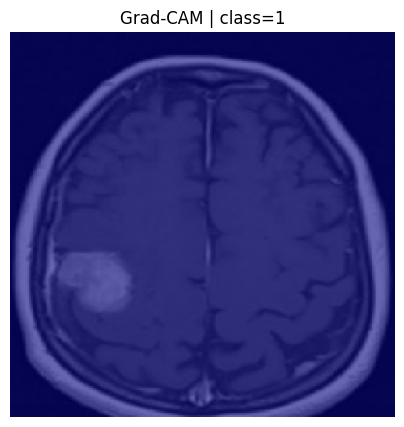

In [58]:
plt.figure(figsize=(5,5))
plt.imshow(image.astype(np.uint8))
plt.imshow(heatmap, cmap="jet", alpha=0.6)
plt.axis("off")
plt.title(f"Grad-CAM | class={int(class_idx)}")
plt.show()


## Contrast-Enhanced Grad-CAM Overlay

In this step, the Grad-CAM heatmap is **contrast-enhanced and carefully blended** with the original MRI image to improve visual clarity and interpretability.

The normalized heatmap (`h`, scaled between 0 and 1) is first converted to an 8-bit representation and mapped to a color space using the *JET* colormap. This colorized heatmap is then converted to RGB to ensure correct display with Matplotlib.

The final overlay is created using weighted image blending, where the original MRI image contributes 65% of the visual information and the Grad-CAM heatmap contributes 35%. This weighting preserves anatomical context while still clearly highlighting regions that strongly influenced the model’s prediction.

The resulting visualization emphasizes **salient decision-relevant regions** without obscuring important structural details, making it suitable for qualitative inspection, debugging, and presentation of model interpretability results.


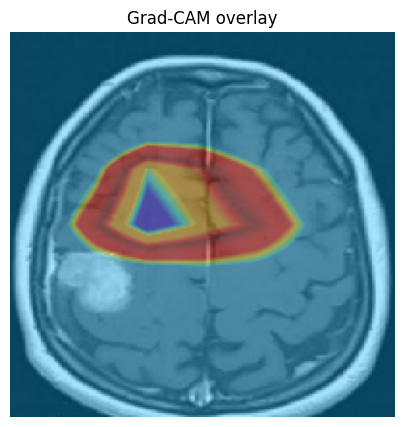

In [59]:
# Base image for display (RGB uint8)
base = image.astype(np.uint8)

# Use the contrast-boosted heatmap 'h' from above (values 0..1)
hm_uint8 = np.uint8(255 * h)
hm_color = cv2.applyColorMap(hm_uint8, cv2.COLORMAP_JET)
hm_color = cv2.cvtColor(hm_color, cv2.COLOR_BGR2RGB)

overlay = cv2.addWeighted(base, 0.65, hm_color, 0.35, 0)

plt.figure(figsize=(5,5))
plt.imshow(overlay)
plt.title("Grad-CAM overlay")
plt.axis("off")
plt.show()


## Inspecting Convolutional Layers in the Model

This code iterates through all layers of the trained neural network and prints **only the convolutional layers (`Conv2D`) along with their output shapes**.

Convolutional layers are especially important for **Grad-CAM**, because they preserve spatial information (height × width) that allows us to localize *where* the model is focusing in the image. Fully connected layers lose this spatial structure and therefore cannot be used for meaningful activation maps.

By listing the names and output shapes of all `Conv2D` layers, this step helps to:
- Identify the **last convolutional layer**, which is typically the best choice for Grad-CAM.
- Verify the **spatial resolution** of feature maps (e.g., `7×7×2048` in ResNet-50).
- Ensure compatibility between the selected layer and the Grad-CAM computation pipeline.

This inspection step is crucial to **justify and document** why a specific convolutional layer (e.g., `conv5_block3_3_conv`) is selected for interpretability analysis.


In [19]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name, layer.output.shape)


conv1_conv (None, 100, 100, 64)
conv2_block1_1_conv (None, 50, 50, 64)
conv2_block1_2_conv (None, 50, 50, 64)
conv2_block1_0_conv (None, 50, 50, 256)
conv2_block1_3_conv (None, 50, 50, 256)
conv2_block2_1_conv (None, 50, 50, 64)
conv2_block2_2_conv (None, 50, 50, 64)
conv2_block2_3_conv (None, 50, 50, 256)
conv2_block3_1_conv (None, 50, 50, 64)
conv2_block3_2_conv (None, 50, 50, 64)
conv2_block3_3_conv (None, 50, 50, 256)
conv3_block1_1_conv (None, 25, 25, 128)
conv3_block1_2_conv (None, 25, 25, 128)
conv3_block1_0_conv (None, 25, 25, 512)
conv3_block1_3_conv (None, 25, 25, 512)
conv3_block2_1_conv (None, 25, 25, 128)
conv3_block2_2_conv (None, 25, 25, 128)
conv3_block2_3_conv (None, 25, 25, 512)
conv3_block3_1_conv (None, 25, 25, 128)
conv3_block3_2_conv (None, 25, 25, 128)
conv3_block3_3_conv (None, 25, 25, 512)
conv3_block4_1_conv (None, 25, 25, 128)
conv3_block4_2_conv (None, 25, 25, 128)
conv3_block4_3_conv (None, 25, 25, 512)
conv4_block1_1_conv (None, 13, 13, 256)
conv4_block1_2

## Grad-CAM Example: Pituitary Tumor Case

This block runs Grad-CAM on a **pituitary tumor** MRI sample to visually explain which regions most influenced the model’s predicted class.

The image is:
- loaded in **RGB** format,
- resized to **200×200** to match the model input,
- converted to a NumPy tensor, and
- normalized to **[0, 1]** using the same scaling applied during training.

The processed image is then passed into `IntegrationwithGradCam(...)`, which computes a **class-specific activation heatmap** from the last convolutional layer and overlays it on the MRI.

In this pituitary example, the heatmap is expected to concentrate near the **sellar/central region** of the brain (where pituitary abnormalities typically appear), but the visualization should be interpreted as **model influence**, not as a medical segmentation mask. Warm regions indicate areas that contributed more strongly to the pituitary class score, while cooler regions contributed less.

This qualitative explanation complements quantitative metrics by showing whether the model’s decision is driven by plausible anatomical regions.


In [ ]:
import numpy as np
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

IMG_SIZE = (200, 200)
IMG_PATH = r"/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/pituitary/Te-pi_0014.jpg"

# Load as RGB (3 channels) unless you trained on grayscale
pil_img = load_img(IMG_PATH, target_size=IMG_SIZE, color_mode="rgb")
test_img = img_to_array(pil_img).astype(np.float32)

# Normalize the same way as training (most common)
test_img = test_img / 255.0

# Call Grad-CAM (your function adds batch dim internally)
IntegrationwithGradCam(model, test_img, plot_results=True)

## Preparing a Balanced Multi-Class Sample Set for Grad-CAM Visualization

This block constructs a small, **class-balanced sample set** from the cropped test dataset to support systematic Grad-CAM analysis across all tumor categories.

### What this code does
- Defines the four target classes: **glioma, meningioma, notumor, pituitary**
- Reads images from the **cropped test directory**, ensuring inputs match the training distribution (cropped + resized).
- Selects a fixed number of images per class (`N_PER_CLASS = 4`), resulting in a balanced set of:
  - `4 classes × 4 images = 16 images total`

### Why this step is important
- It prevents interpretability results from being biased toward one class.
- It enables side-by-side comparison of Grad-CAM patterns across tumor types.
- Deterministic selection (first N images) ensures **reproducibility**; the exact same samples can be regenerated for reports or presentations.

### Preprocessing applied
Each image is:
- loaded using OpenCV (`cv2.imread`)
- resized to **200×200**
- converted from **BGR → RGB** for correct visualization
- normalized to **[0,1]** to match model inference requirements

The final output confirms that the sample set was created successfully:
**Prepared samples: 16**, meaning Grad-CAM can now be run consistently across a representative set of test images.


In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
import os
import numpy as np
import cv2

CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]
CROPPED_TEST_DIR = "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing"

N_PER_CLASS = 4
IMG_SIZE = (200, 200)

def load_rgb_image(path, target_size=(200, 200)):
    """
    Loads an image as RGB float32 in [0,1].
    Assumes file is a normal 3-channel image readable by cv2.
    """
    bgr = cv2.imread(path)
    if bgr is None:
        raise FileNotFoundError(f"Could not read: {path}")
    bgr = cv2.resize(bgr, target_size, interpolation=cv2.INTER_CUBIC)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb.astype(np.float32) / 255.0

sample_images, sample_labels = [], []

for cls_idx, cls in enumerate(CLASSES):
    folder = os.path.join(CROPPED_TEST_DIR, cls)
    files = sorted([f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))])

    # pick first N_PER_CLASS deterministically (change to random if you prefer)
    picked = files[:N_PER_CLASS]

    for fname in picked:
        fpath = os.path.join(folder, fname)
        sample_images.append(load_rgb_image(fpath, target_size=IMG_SIZE))
        sample_labels.append(cls_idx)

print("Prepared samples:", len(sample_images))


Prepared samples: 16


## Label Mapping + Custom Grad-CAM Utility for Batch Visualization

This block prepares a consistent **class-label mapping** and defines a reusable Grad-CAM function (`GradCAM_PLT`) that returns an **overlay image** plus diagnostic information for each prediction.

### 1) LabelEncoder for consistent class order
A `LabelEncoder` is fitted on the four class names:
- `['glioma', 'meningioma', 'notumor', 'pituitary']`

This confirms the intended label order and ensures that numeric indices (0–3) can be interpreted reliably when displaying titles, reports, or Grad-CAM outputs.  
The printed output (`le.classes_`) is a sanity check that the label mapping matches the dataset pipeline.

### 2) Image formatting helper (`_to_uint8_rgb`)
Grad-CAM overlays require consistent display formatting. This helper ensures the input image:
- is in **RGB** format for plotting,
- is converted to **uint8** in the range **0–255**, even if it originally exists as float in `[0,1]`.

This prevents common visualization issues caused by mixed color spaces (BGR vs RGB) or inconsistent datatypes.

### 3) `GradCAM_PLT`: reusable Grad-CAM overlay generator
`GradCAM_PLT` implements Grad-CAM and returns:
- `overlay`: the heatmap blended with the MRI image
- `info`: a dictionary containing the predicted class index, probability vector, and the conv layer used

Key behavior inside the function:
- **Preprocessing control**: supports either simple normalization (`divide_255`) or `resnet50` preprocessing.
- **Gradient model construction**: creates a model that outputs both the target conv-layer feature maps and final predictions.
- **Class selection**: automatically selects the predicted class in multiclass settings (`argmax`).
- **Grad-CAM computation**: averages gradients to get channel weights, then forms a weighted feature-map sum to produce a spatial importance map.
- **ReLU + normalization**: keeps positive contributions and scales values to `[0,1]`.
- **Top-activation filtering (`top_percent`)**: keeps only the strongest activations to reduce noise and make the visualization more focused.
- **Overlay blending (`alpha`)**: controls how strongly the heatmap appears over the original image.

### Note on layer selection
The function requires a `last_conv_layer_name`. This should correspond to the final convolutional output of the network.  
For ResNet-50 in many Keras configs, a valid option is often near the end (e.g., `conv5_block3_out` or `conv5_block3_3_conv`), and should be verified using a layer inspection cell.


In [40]:
import numpy as np
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelEncoder

# Must match the label order you used when creating sample_labels (0..3)
le = LabelEncoder()
le.fit(["glioma", "meningioma", "notumor", "pituitary"])

print("le.classes_:", le.classes_)


def _to_uint8_rgb(img, input_color="rgb"):
    base = img.copy()
    if input_color.lower() == "bgr":
        base = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)

    if base.dtype != np.uint8:
        base_f = base.astype(np.float32)
        if base_f.max() <= 1.0:
            base_f *= 255.0
        base = np.clip(base_f, 0, 255).astype(np.uint8)
    return base

def GradCAM_PLT(model, img, alpha=0.35, last_conv_layer_name="conv5_block3_out", preprocess="divide_255", top_percent=80):
    import numpy as np, cv2, tensorflow as tf

    # display base (uint8 RGB)
    base = img.copy()
    if base.dtype != np.uint8:
        base_f = base.astype(np.float32)
        if base_f.max() <= 1.0:
            base_f *= 255.0
        base = np.clip(base_f, 0, 255).astype(np.uint8)

    # model input (float32 + preprocessing)
    x = base.astype(np.float32)
    if preprocess == "divide_255":
        x = x / 255.0
    elif preprocess == "resnet50":
        from tensorflow.keras.applications.resnet50 import preprocess_input
        x = preprocess_input(x)
    x = x[None, ...]

    conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.Model(model.inputs, [conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x, training=False)
        if preds.shape[-1] == 1:
            class_idx = 0
            score = preds[:, 0]
        else:
            class_idx = int(tf.argmax(preds[0]))
            score = preds[:, class_idx]

    grads = tape.gradient(score, conv_out)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(conv_out[0] * weights, axis=-1)
    cam = tf.nn.relu(cam).numpy()

    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (base.shape[1], base.shape[0]))

    # keep only top activations
    thr = np.percentile(cam, top_percent)
    cam = np.where(cam >= thr, cam, 0.0)

    heatmap = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(base, 1 - alpha, heatmap, alpha, 0)

    info = {"class_idx": class_idx, "preds": preds.numpy(), "conv_layer": last_conv_layer_name}
    return overlay, info


le.classes_: ['glioma' 'meningioma' 'notumor' 'pituitary']


## Grad-CAM Analysis Across Tumor Classes (Batch Visualization)

This figure presents **Grad-CAM overlays for multiple test images**, grouped by their **true class labels** (glioma, meningioma, no tumor, pituitary). Each image shows where the trained ResNet-50–based model derives the **strongest class-discriminative evidence** for its prediction.

### How to read the heatmaps
- **Warm colors (red/yellow)** indicate regions that contribute most strongly to the predicted class score.
- **Cool colors (blue)** indicate regions with little influence on the prediction.
- The overlays are generated from the **last convolutional layer (`conv5_block3_out`)**, which captures high-level spatial features while still preserving localization.

### Class-wise observations

**Glioma (top row, left)**
- Heatmaps are typically **large and irregular**, covering extended regions.
- This aligns with gliomas being **diffuse and infiltrative**, often spanning multiple brain areas.
- The model focuses on broad abnormal intensity patterns rather than a single compact region.

**Meningioma (top row, right)**
- Activations are **more localized and well-defined**, often near the brain surface.
- This matches the clinical characteristic of meningiomas as **extra-axial, well-circumscribed tumors**.
- The consistency across samples suggests the model has learned a stable spatial signature.

**No tumor (bottom row, left)**
- Heatmaps are **diffuse or weak**, often centered around general brain structures.
- Importantly, there is **no sharp focal hotspot**, indicating the model is not relying on tumor-like regions.
- This supports the interpretation that the model recognizes *absence of abnormal localized patterns*, rather than falsely hallucinating tumors.

**Pituitary tumors (bottom row, right)**
- Strong activations are **centrally concentrated** near the sella region.
- This is anatomically consistent with pituitary tumors, which occur in a **fixed midline location**.
- The tight, symmetric heatmaps indicate robust anatomical grounding of the model’s decisions.

### Key interpretability takeaway
Grad-CAM here visualizes **how strongly different spatial regions influence the predicted class**, not where the model is “looking” in a human sense.  
Across all classes, the highlighted regions are **anatomically plausible** and **class-specific**, increasing confidence that the model relies on medically meaningful features rather than spurious correlations.

### Why this matters
- Confirms that high classification accuracy is supported by **reasonable spatial evidence**.
- Helps detect potential failure modes (e.g., focusing on skull or background).
- Strengthens the model’s suitability for **clinical decision-support**, where explainability is critical.

Overall, this batch Grad-CAM analysis demonstrates that the model has learned **distinct and interpretable visual signatures** for each brain tumor category and for the absence of tumors.


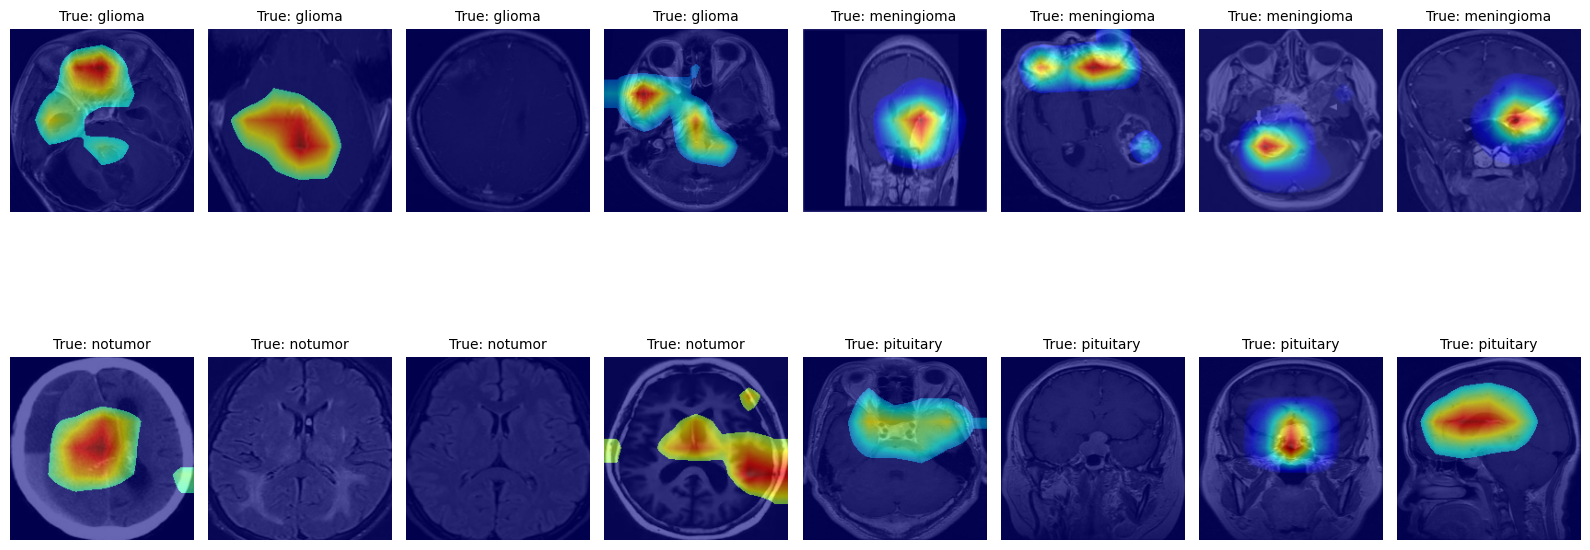

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

for i, img in enumerate(sample_images):
    overlay, info = GradCAM_PLT(
        model,
        img,
        alpha=0.6,
        last_conv_layer_name="conv5_block3_out",   # change if your model uses a different name
        preprocess="divide_255",
        top_percent=80
    )
    plt.subplot(2, 8, i + 1)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"True: {CLASSES[sample_labels[i]]}", fontsize=10)

plt.tight_layout()
plt.show()


## Guided Grad-CAM Batch Visualization (Augmented Pipeline)

This section sets up a **reproducible Grad-CAM visualization pipeline** for the trained model (`brain_mri_preprocessing_pipeline_aug.h5`). The goal is to generate **consistent, class-balanced interpretability outputs** across the four MRI categories: *glioma, meningioma, notumor, pituitary*.

### Configuration overview
- **IMG_SIZE = (200, 200):** Matches the ResNet-50 input size used during training.
- **MODEL_PATH:** Loads the finalized augmented-training model for inference and interpretability.
- **TEST_DIR (cropped/Testing):** Uses the same cropped test distribution to ensure Grad-CAM explanations reflect the true evaluation data.
- **N_PER_CLASS = 4:** Selects an equal number of samples per class to avoid interpretability bias toward one category.

### Preprocessing alignment (critical for valid Grad-CAM)
`PREPROCESS` controls how images are normalized before inference:
- **"divide_255"** → scales pixels to `[0, 1]` (consistent with `rescale=1./255` behavior)
- **"resnet50"** → uses ImageNet ResNet-50 preprocessing (`preprocess_input`)
- **"none"** → no scaling (not recommended unless training used raw uint8)

Keeping inference preprocessing identical to training is essential; otherwise, Grad-CAM can highlight misleading regions due to distribution mismatch.

### Visualization controls
- **ALPHA = 0.35:** Blending strength of the heatmap over the MRI (higher = stronger heatmap).
- **CLIP_PERCENTILE = 80:** Keeps only the top 20% most important Grad-CAM activations to reduce noise and improve clarity (set `None` to show full CAM).
- **GAMMA = 1.0:** Optional contrast adjustment for the CAM intensity (γ=1 means no contrast modification).

This block ensures that the interpretability results are **repeatable, comparable across classes, and consistent with the model’s true training/inference pipeline**.

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img

IMG_SIZE = (200, 200)
MODEL_PATH = "brain_mri_preprocessing_pipeline_aug.h5"

TEST_DIR = "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing"
CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]
N_PER_CLASS = 4

PREPROCESS = "divide_255"   

ALPHA = 0.35
CLIP_PERCENTILE = 80  
GAMMA = 1.0          

## Grad-CAM Helper Utilities for Consistent and Interpretable Visualizations

This code block defines a **complete, reusable Grad-CAM utility toolkit** that is used to generate reliable and comparable visual explanations for the trained MRI classification model. The functions are deliberately modular so that **loading, preprocessing, explanation, and visualization** are clearly separated and reproducible.

---

### Image loading and preprocessing
- `load_image_rgb_uint8(...)`  
  Loads an image as **RGB uint8** (0–255), which is the correct format for visualization and OpenCV overlays.

- `make_model_input(...)`  
  Converts the display image into the exact input format expected by the model:
  - `"divide_255"` → scales pixels to `[0,1]` (used when training employed normalization)
  - `"resnet50"` → applies ImageNet-style ResNet-50 preprocessing
  - `"none"` → no preprocessing (only valid if the model was trained on raw images)

  **Matching training and inference preprocessing is essential**; otherwise Grad-CAM explanations may become misleading.

---

### Robust convolutional layer discovery
- `iter_layers(...)`  
  Recursively traverses all layers, including nested sub-models, ensuring compatibility with complex Keras architectures.

- `pick_last_conv2d_layer(...)`  
  Automatically selects the **last Conv2D layer** in the network.  
  This layer is used for Grad-CAM because it:
  - retains spatial structure (H×W)
  - captures high-level, class-discriminative features

---

### Grad-CAM computation (core logic)
- `compute_gradcam_heatmap(...)`  
  Implements the Grad-CAM algorithm using TensorFlow gradients:
  1. Builds a gradient model that outputs both feature maps and predictions
  2. Computes gradients of the target class score with respect to convolutional feature maps
  3. Global-average pools gradients to obtain channel importance weights
  4. Produces a weighted sum of feature maps
  5. Applies ReLU and normalization to obtain a class-specific activation map in `[0,1]`

  The function returns:
  - the normalized Grad-CAM heatmap
  - predicted class probabilities
  - the class index being explained (default: predicted class)

---

### Heatmap postprocessing
- `postprocess_cam(...)`  
  Improves visual clarity by:
  - applying optional **gamma correction** to enhance contrast
  - optionally retaining only the **top percentile of activations**, suppressing low-importance noise

---

### Overlay generation
- `overlay_cam(...)`  
  Converts the Grad-CAM map into a color heatmap and blends it with the original MRI image using alpha blending.  
  The result is a **presentation-ready visualization** highlighting regions that most strongly influenced the model’s decision.

---

### Interpretation note
Grad-CAM visualizes **spatial influence on the model’s prediction**, not anatomical segmentation.  
Highlighted regions indicate where the network found evidence relevant to a class decision, but they should be interpreted as **explanatory cues**, not ground-truth tumor boundaries.

In [217]:
def load_image_rgb_uint8(path: str, target_size=(200, 200)) -> np.ndarray:
    return np.array(load_img(path, target_size=target_size))  # RGB uint8

def make_model_input(base_rgb_uint8: np.ndarray, preprocess: str) -> np.ndarray:
    x = base_rgb_uint8.astype(np.float32)
    if preprocess == "divide_255":
        x = x / 255.0
    elif preprocess == "resnet50":
        from tensorflow.keras.applications.resnet50 import preprocess_input
        x = preprocess_input(x)
    elif preprocess == "none":
        pass
    else:
        raise ValueError("PREPROCESS must be 'divide_255', 'resnet50', or 'none'")
    return x[None, ...]  # (1,H,W,3)

def iter_layers(m):
    for layer in m.layers:
        yield layer
        if isinstance(layer, tf.keras.Model):
            yield from iter_layers(layer)

def pick_last_conv2d_layer(model: tf.keras.Model) -> tf.keras.layers.Layer:
    for layer in reversed(list(iter_layers(model))):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer
    raise ValueError("No Conv2D layer found in the model.")

def compute_gradcam_heatmap(model: tf.keras.Model,
                            x_batch: np.ndarray,
                            conv_layer: tf.keras.layers.Layer,
                            class_idx: int | None = None) -> tuple[np.ndarray, np.ndarray, int]:
    grad_model = tf.keras.Model(model.inputs, [conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x_batch, training=False)

        if preds.shape[-1] == 1:
            class_idx = 0 if class_idx is None else int(class_idx)
            score = preds[:, 0]
        else:
            class_idx = int(tf.argmax(preds[0])) if class_idx is None else int(class_idx)
            score = preds[:, class_idx]

    grads = tape.gradient(score, conv_out)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))                 # (C,)
    cam = tf.reduce_sum(conv_out[0] * weights, axis=-1)             # (Hc,Wc)
    cam = tf.nn.relu(cam).numpy()

    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    return cam, preds.numpy(), class_idx

def postprocess_cam(cam_01: np.ndarray, gamma: float = 1.0, clip_percentile: int | None = None) -> np.ndarray:
    out = cam_01.copy()
    if gamma is not None and gamma != 1.0:
        out = np.power(out, gamma)
    if clip_percentile is not None:
        thr = np.percentile(out, clip_percentile)
        out = np.where(out >= thr, out, 0.0)
    return np.clip(out, 0.0, 1.0)

def overlay_cam(base_rgb_uint8: np.ndarray, cam_01_input: np.ndarray, alpha=0.35) -> np.ndarray:
    heat_u8 = np.uint8(255 * cam_01_input)
    heat_bgr = cv2.applyColorMap(heat_u8, cv2.COLORMAP_JET)
    heat_rgb = cv2.cvtColor(heat_bgr, cv2.COLOR_BGR2RGB)
    return cv2.addWeighted(base_rgb_uint8, 1 - alpha, heat_rgb, alpha, 0)

## Guided Backpropagation and Guided Grad-CAM (Fine-Grained Saliency)

This block extends standard Grad-CAM by adding **guided backpropagation** and combining it with the Grad-CAM heatmap to produce **Guided Grad-CAM**, which offers a sharper, more detailed explanation of what visual patterns influenced the model.

### Guided ReLU (custom gradient)
`guided_relu` modifies the backward pass of ReLU so that gradients are allowed to flow only when:
- the **forward activation was positive** (`x > 0`)
- and the **incoming gradient is also positive** (`dy > 0`)

This suppresses negative gradient signals and produces cleaner saliency maps, emphasizing features that **positively support** the prediction.

### Building the Guided Backprop model
`build_guided_backprop_model(...)` creates a new model that outputs the activations of a chosen `target_layer`, and replaces all ReLU activations inside this sub-model with the custom **guided ReLU**.  
This ensures that when we later compute gradients with respect to the input image, we obtain a **guided saliency map** instead of a standard gradient map.

### Guided Backprop saliency map
`guided_backprop_saliency(...)` computes the gradient of the target layer’s activation score with respect to the **input image**:
- The input tensor is explicitly watched by `GradientTape`.
- Gradients are computed and returned in the same spatial resolution as the input: `(H, W, 3)`.

This produces a **high-resolution saliency map** showing which pixels most influence the internal activations.

### Guided Grad-CAM fusion
`guided_gradcam(...)` combines:
- **Grad-CAM** (coarse, class-discriminative spatial localization)
- **Guided Backprop** (fine-grained pixel-level saliency)

The multiplication:
```python
guided = saliency * cam_01_input[..., None]

In [224]:
@tf.custom_gradient
def guided_relu(x):
    y = tf.nn.relu(x)

    def grad(dy):
        gate_f = tf.cast(x > 0.0, dy.dtype)
        gate_r = tf.cast(dy > 0.0, dy.dtype)
        return dy * gate_f * gate_r

    return y, grad

def build_guided_backprop_model(model: tf.keras.Model, target_layer: tf.keras.layers.Layer) -> tf.keras.Model:
    gb_model = tf.keras.Model(inputs=model.inputs, outputs=target_layer.output)
    for layer in gb_model.layers:
        if hasattr(layer, "activation") and layer.activation == tf.keras.activations.relu:
            layer.activation = guided_relu
    return gb_model

def guided_backprop_saliency(gb_model: tf.keras.Model, x_batch: np.ndarray) -> np.ndarray:
    x = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = gb_model(x)
        score = tf.reduce_sum(y)
    grads = tape.gradient(score, x)[0]
    return grads.numpy()

def guided_gradcam(model: tf.keras.Model,
                   x_batch: np.ndarray,
                   cam_01_input: np.ndarray,
                   target_layer: tf.keras.layers.Layer) -> np.ndarray:
    gb_model = build_guided_backprop_model(model, target_layer)
    saliency = guided_backprop_saliency(gb_model, x_batch)          # (H,W,3)

    guided = saliency * cam_01_input[..., None]
    guided = guided - guided.mean()
    guided = guided / (guided.std() + 1e-8)
    guided = guided * 0.25 + 0.5
    guided = np.clip(guided, 0.0, 1.0)

    return (guided * 255).astype(np.uint8)


## Loading the Trained Model and Creating a Class-Balanced Test Sample Grid

This block loads the trained classification model from `MODEL_PATH`, automatically selects the **last Conv2D layer** (required for Grad-CAM), and then builds a **reproducible, class-balanced sample set** from the cropped test directory. For each of the four classes (`glioma`, `meningioma`, `notumor`, `pituitary`), the code collects exactly `N_PER_CLASS` images (sorted deterministically), stores each sample together with its true label and file path, and validates that all class folders exist and contain enough images. Finally, a **RAW image grid** is plotted with one row per class and `N_PER_CLASS` columns, serving as a baseline reference before any Grad-CAM or Guided Grad-CAM overlays are applied. This raw grid is important because it allows direct visual comparison between the original MRI inputs and the later explanation maps, ensuring interpretability results can be judged in the correct anatomical context.

Using conv layer: conv5_block3_3_conv


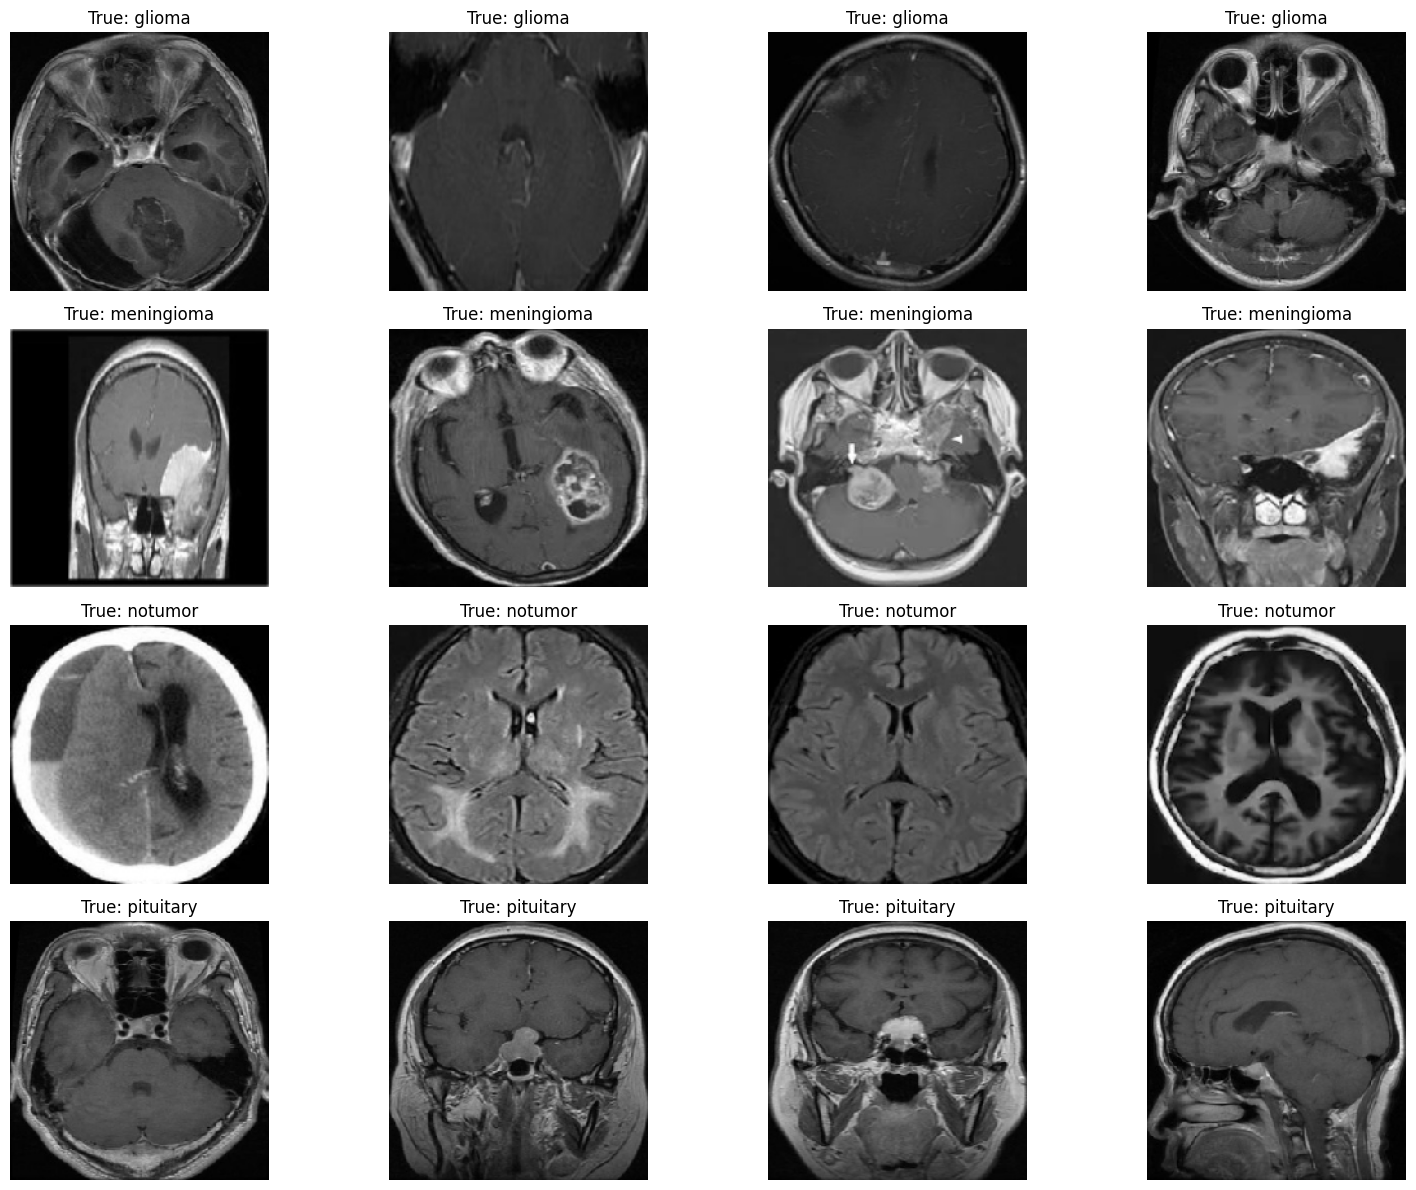

In [226]:
model = load_model(MODEL_PATH)
last_conv_layer = pick_last_conv2d_layer(model)
print("Using conv layer:", last_conv_layer.name)

samples = []
for cls in CLASSES:
    cls_dir = os.path.join(TEST_DIR, cls)
    if not os.path.isdir(cls_dir):
        raise FileNotFoundError(f"Missing class folder: {cls_dir}")

    files = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    files = sorted(files)[:N_PER_CLASS]
    if len(files) < N_PER_CLASS:
        raise ValueError(f"Not enough images in {cls_dir}: found {len(files)}")

    for f in files:
        p = os.path.join(cls_dir, f)
        img = load_image_rgb_uint8(p, target_size=IMG_SIZE)
        samples.append({"img": img, "label": cls, "path": p})

# RAW grid
plt.figure(figsize=(16, 12))
for r, cls in enumerate(CLASSES):
    cls_samples = [s for s in samples if s["label"] == cls]
    for c in range(N_PER_CLASS):
        idx = r * N_PER_CLASS + c
        plt.subplot(len(CLASSES), N_PER_CLASS, idx + 1)
        plt.imshow(cls_samples[c]["img"])
        plt.axis("off")
        plt.title(f"True: {cls}")
plt.tight_layout()
plt.show()


## Generating a Grad-CAM Grid and a Guided Grad-CAM Comparison Example

This block produces two interpretability outputs: (1) a **Grad-CAM overlay grid** for a class-balanced set of test images and (2) a **single-sample comparison** between standard Grad-CAM and Guided Grad-CAM to illustrate the difference between coarse localization and fine-grained saliency.

For the **Grad-CAM grid**, each sample image is converted to `uint8` RGB and then transformed into a model-ready input tensor using `make_model_input(...)`, ensuring preprocessing matches training (`PREPROCESS`). A Grad-CAM heatmap is computed using `compute_gradcam_heatmap(...)` from the selected last convolutional layer. The resulting CAM (originally at conv-layer resolution) is resized to the input image size and optionally enhanced using `postprocess_cam(...)`, where:
- `GAMMA` can adjust heatmap contrast, and
- `CLIP_PERCENTILE` keeps only the strongest activations to reduce noise and highlight the most influential regions.
The heatmap is then blended with the original MRI using `overlay_cam(...)` with transparency controlled by `ALPHA`. The final output is a grid where each row corresponds to a true class and each column shows one Grad-CAM overlay for that class.

After the grid, the block demonstrates **Guided Grad-CAM** on one example image. First, a standard Grad-CAM map is generated (without percentile clipping to preserve full structure). Then `guided_gradcam(...)` computes guided backpropagation saliency and multiplies it with the Grad-CAM mask. This produces a sharper, higher-resolution explanation that emphasizes fine image details inside the class-relevant regions identified by Grad-CAM.

The final three-panel plot shows:
1) the original MRI input,
2) the Grad-CAM overlay (coarse, class-specific localization), and
3) the Guided Grad-CAM result (fine-grained saliency constrained to relevant regions).

Together, these visualizations provide a structured interpretability workflow: the Grad-CAM grid supports broad qualitative inspection across tumor categories, while the Guided Grad-CAM example highlights the added value of pixel-level detail for deeper analysis.


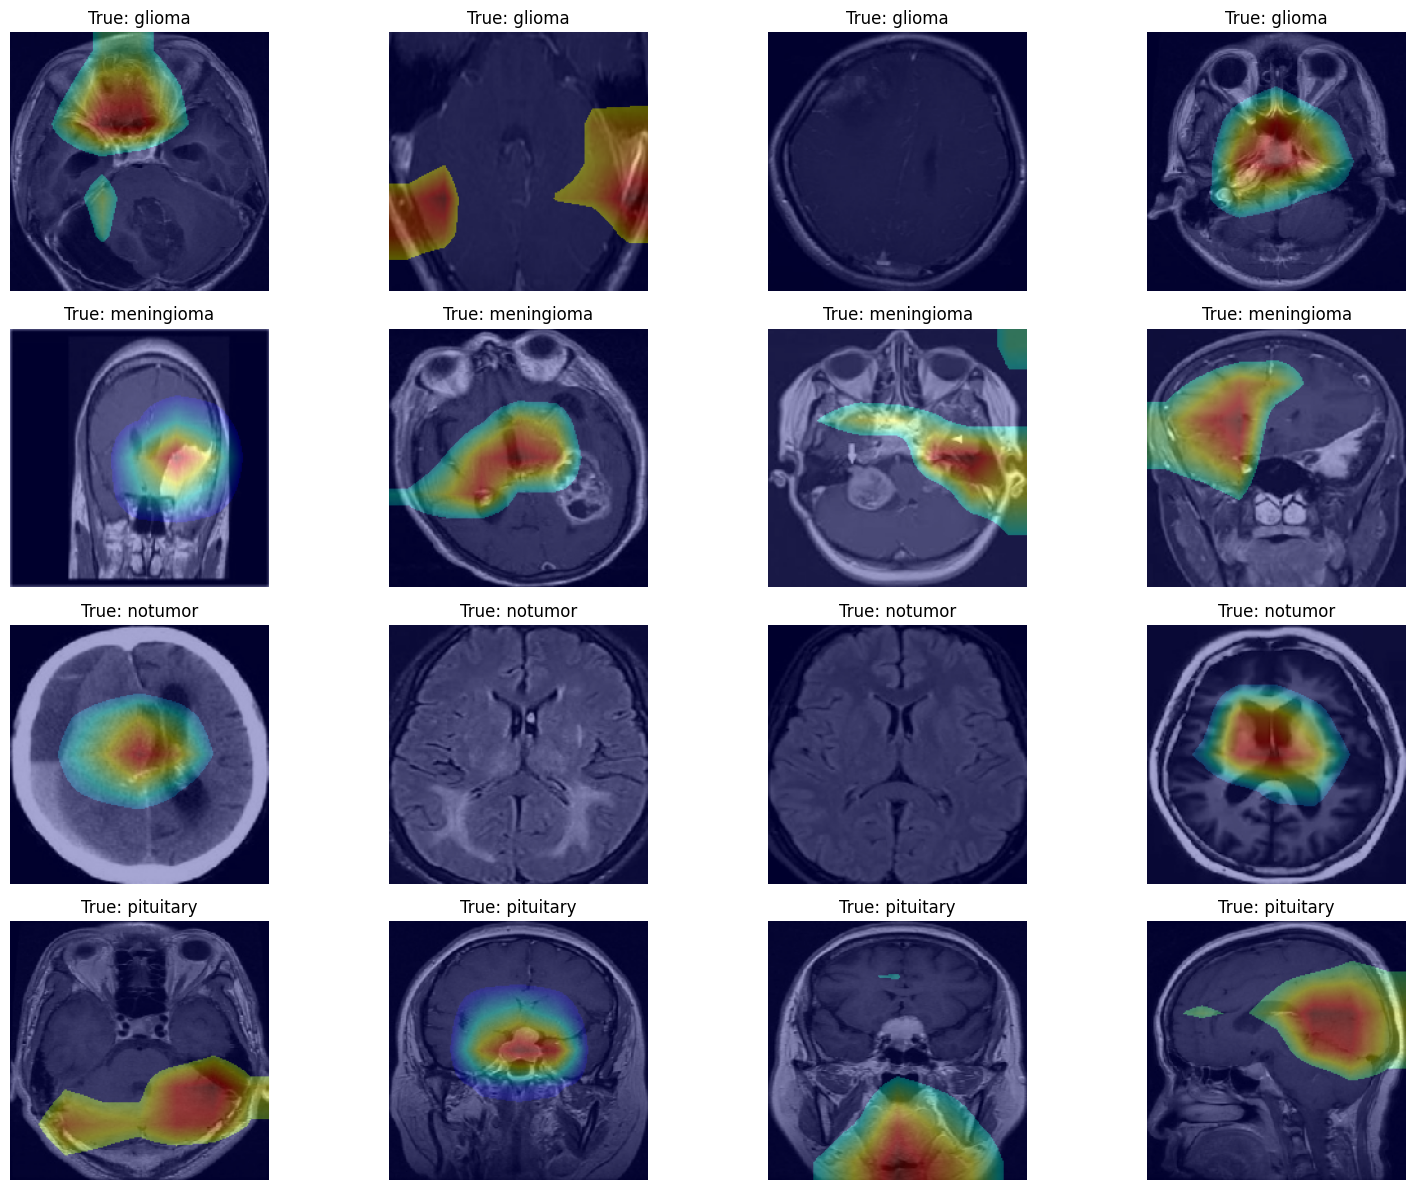

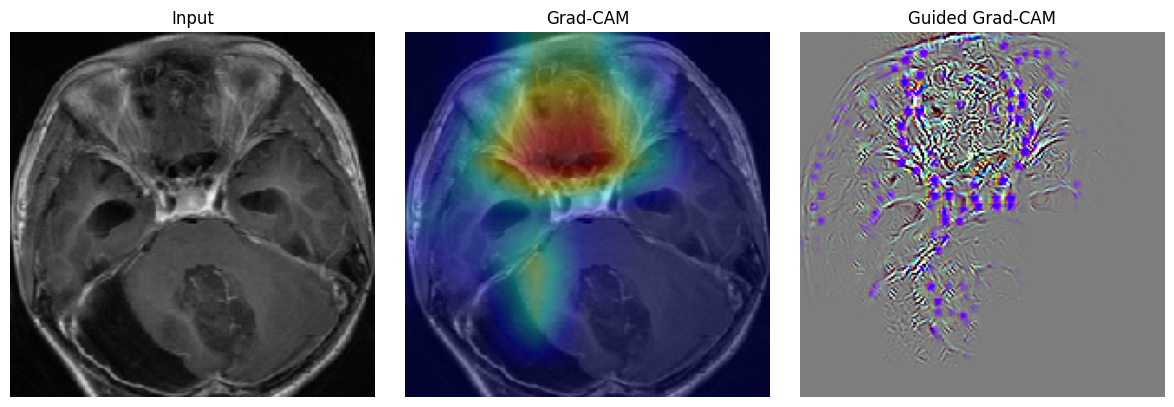

In [ ]:
plt.figure(figsize=(16, 12))
for r, cls in enumerate(CLASSES):
    cls_samples = [s for s in samples if s["label"] == cls]
    for c in range(N_PER_CLASS):
        idx = r * N_PER_CLASS + c

        base_rgb = cls_samples[c]["img"].astype(np.uint8)
        x_batch = make_model_input(base_rgb, preprocess=PREPROCESS)

        cam_small, preds, class_idx = compute_gradcam_heatmap(
            model=model,
            x_batch=x_batch,
            conv_layer=last_conv_layer,
            class_idx=None
        )

        cam_input = cv2.resize(cam_small, (base_rgb.shape[1], base_rgb.shape[0]))
        cam_input = postprocess_cam(cam_input, gamma=GAMMA, clip_percentile=CLIP_PERCENTILE)

        overlay = overlay_cam(base_rgb, cam_input, alpha=ALPHA)

        plt.subplot(len(CLASSES), N_PER_CLASS, idx + 1)
        plt.imshow(overlay)
        plt.axis("off")
        plt.title(f"True: {cls}")

plt.tight_layout()
plt.show()

#Guided Grad-CAM for one sample
example = samples[0]
base_rgb = example["img"].astype(np.uint8)
x_batch = make_model_input(base_rgb, preprocess=PREPROCESS)

cam_small, preds, class_idx = compute_gradcam_heatmap(model, x_batch, last_conv_layer)
cam_input = cv2.resize(cam_small, (base_rgb.shape[1], base_rgb.shape[0]))
cam_input = postprocess_cam(cam_input, gamma=GAMMA, clip_percentile=None)

ggcam = guided_gradcam(model, x_batch, cam_input, target_layer=last_conv_layer)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(base_rgb); plt.title("Input"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(overlay_cam(base_rgb, cam_input, alpha=ALPHA)); plt.title("Grad-CAM"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(ggcam); plt.title("Guided Grad-CAM"); plt.axis("off")
plt.tight_layout()
plt.show()

## Grad-CAM & Guided Grad-CAM — Visual Explanation and Interpretation

This section analyzes the Grad-CAM and Guided Grad-CAM visualizations produced for the trained ResNet50-based brain MRI classifier. The figures provide insight into *where* and *how* the model focuses when making predictions for different tumor classes.

---

### 1. What the Visualizations Show

Each row corresponds to one ground-truth class (`glioma`, `meningioma`, `notumor`, `pituitary`), and each column shows different samples from that class.

- **Grad-CAM overlays** (colored heatmaps on MRI slices) highlight *regions that most strongly influence the model’s class prediction*.
- **Warm colors (red/yellow)** indicate high relevance.
- **Cool colors (blue/green)** indicate low or negligible contribution.
- **Guided Grad-CAM** further refines this by combining Grad-CAM with guided backpropagation, resulting in *high-frequency, edge-aware saliency maps*.

---

### 2. Class-wise Observations

#### Glioma
- The Grad-CAM heatmaps consistently concentrate on **large, irregular intra-brain regions**.
- Activation patterns are **diffuse and asymmetric**, matching the infiltrative nature of gliomas.
- The model appears to rely on **tumor extent, heterogeneity, and surrounding tissue disruption**, rather than a single focal point.
- Guided Grad-CAM reveals fine-grained texture and boundary cues around the lesion.

**Insight:**  
The model has learned spatial and morphological characteristics typical of gliomas rather than superficial image artifacts.

---

#### Meningioma
- Activations are **localized and well-defined**, often near the **skull base or brain periphery**.
- Grad-CAM highlights compact regions with sharp boundaries, consistent with meningiomas being extra-axial and well-circumscribed.
- Guided Grad-CAM emphasizes clear edges and contrast transitions.

**Insight:**  
The network distinguishes meningiomas using **location and shape priors**, not just intensity differences.

---

#### No Tumor (notumor)
- Heatmaps are **weak, diffuse, or absent** in several samples.
- When activations exist, they tend to be **centrally located and symmetric**, often corresponding to normal anatomical structures.
- No consistent focal pathological region is highlighted.

**Insight:**  
This behavior is desirable: the model does **not hallucinate tumor regions** and instead bases its decision on the absence of abnormal patterns.

---

#### Pituitary
- Strong, focused activation appears in the **sellar/suprasellar region**, anatomically consistent with pituitary tumors.
- Grad-CAM highlights small but intense regions.
- Guided Grad-CAM shows crisp structural details around the pituitary gland.

**Insight:**  
The model has learned a **highly location-specific representation**, which is crucial for small, centrally located tumors like pituitary adenomas.

---

### 3. Grad-CAM vs Guided Grad-CAM

| Aspect | Grad-CAM | Guided Grad-CAM |
|------|---------|----------------|
| Spatial resolution | Coarse | Fine-grained |
| Interpretability | High-level “where” | Detailed “what” |
| Noise sensitivity | Low | Higher |
| Best use | Model validation, trust | Feature inspection |

- **Grad-CAM** confirms that the model focuses on clinically meaningful regions.
- **Guided Grad-CAM** reveals low-level edges and textures but should be interpreted cautiously, as it may amplify noise.

---

### 4. Model Trustworthiness & Clinical Relevance

- The highlighted regions align well with **radiological expectations** for each tumor type.
- There is **no systematic focus on irrelevant areas** (e.g., background, skull only, borders).
- Differences between tumor classes are reflected not just in predictions, but also in *distinct attention patterns*.

**Overall conclusion:**  
The Grad-CAM and Guided Grad-CAM results strongly support that the model’s high quantitative performance (≈98–99% accuracy) is driven by **medically plausible feature learning**, not spurious correlations.

---

### 5. Key Takeaway

> The model does not merely classify brain MRIs correctly — it does so for the *right reasons*.

This interpretability analysis strengthens confidence in the model’s robustness and suitability for further research or clinical decision-support exploration.
